set the imports

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# import mplfinance as mpf
import yfinance as yf
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from talib import abstract
# add base to the modules
from indicators import indicators as ind
from indicators import normalize as nor
from matplotlib import pyplot as plt
from typing import Union, Tuple

# plt.style.use('dark_background')
%matplotlib inline

### Set the symbol

In [2]:
symbol = "QQQ"

In [3]:
def load_ticker(sym, period="MAX", interval="1d"):
    spy = yf.Ticker(sym)
    return spy.history(period, interval).reset_index()

In [4]:
### load ticker function

In [5]:
df = load_ticker(symbol)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5361 entries, 0 to 5360
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          5361 non-null   datetime64[ns]
 1   Open          5361 non-null   float64       
 2   High          5361 non-null   float64       
 3   Low           5361 non-null   float64       
 4   Close         5361 non-null   float64       
 5   Volume        5361 non-null   int64         
 6   Dividends     5361 non-null   float64       
 7   Stock Splits  5361 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 335.2 KB


In [6]:
print(df.head())

Date   Open   High    Low  Close   Volume  Dividends  Stock Splits
0 1999-03-10  44.58  44.61  43.84  44.52  5232000        0.0           0.0
1 1999-03-11  44.85  45.11  43.87  44.74  9688600        0.0           0.0
2 1999-03-12  44.58  44.61  43.30  43.65  8743600        0.0           0.0
3 1999-03-15  43.98  44.96  43.52  44.90  6369000        0.0           0.0
4 1999-03-16  45.10  45.48  44.61  45.29  4905800        0.0           0.0


## Plot the data to get an idea of the shape

<Figure size 864x864 with 0 Axes>

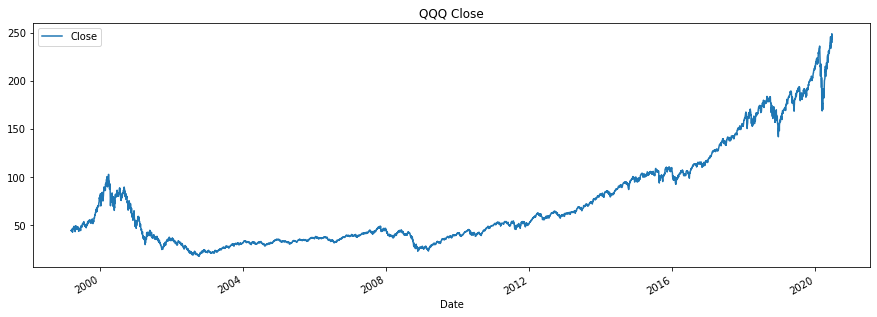

In [7]:
plt.figure(figsize=(12,12))
# plot the chart
df.plot(x="Date", y='Close', kind="line", title=f"{symbol} Close", figsize=(15,5))
plt.legend(loc="best")

## apply indicators

In [8]:
df['Mid'] = ind.mid(df['Open'].values, df['Close'].values)

In [9]:
indicator_spread = (3, 6, 12, 24, 48, 96, 192)
WINDOW = 200

In [10]:
def get_price_indicators(df: pd.DataFrame, periods: tuple)->pd.DataFrame:
    f = df[['High', 'Low', 'Mid']]
    for i in periods:
        bb2u, _, bb2l = ind.bbands(df['Mid'].values, i, 2.)
        bb3u, _, bb3l = ind.bbands(df['Mid'].values, i, 3.)
        ku, kl, _ = ind.keltner_channels(df['High'].values, df['Low'].values, df['Close'].values, i)
        f[f'BB3U_{i}'] = bb3u
        f[f'BB2U_{i}'] = bb2u
        f[f'KELU_{i}'] = ku
        f[f'EMA_{i}'] = ind.ema(df['Mid'].values, i)
        f[f'LREG_{i}'] = ind.rolling_lin(df['Mid'].values, i)
        f[f'SMA_{i}'] = ind.sma(df['Mid'].values, i)
        f[f'KELL_{i}'] = kl
        f[f'BB3L_{i}'] = bb3l
        f[f'BB2L_{i}'] = bb2l
    return f

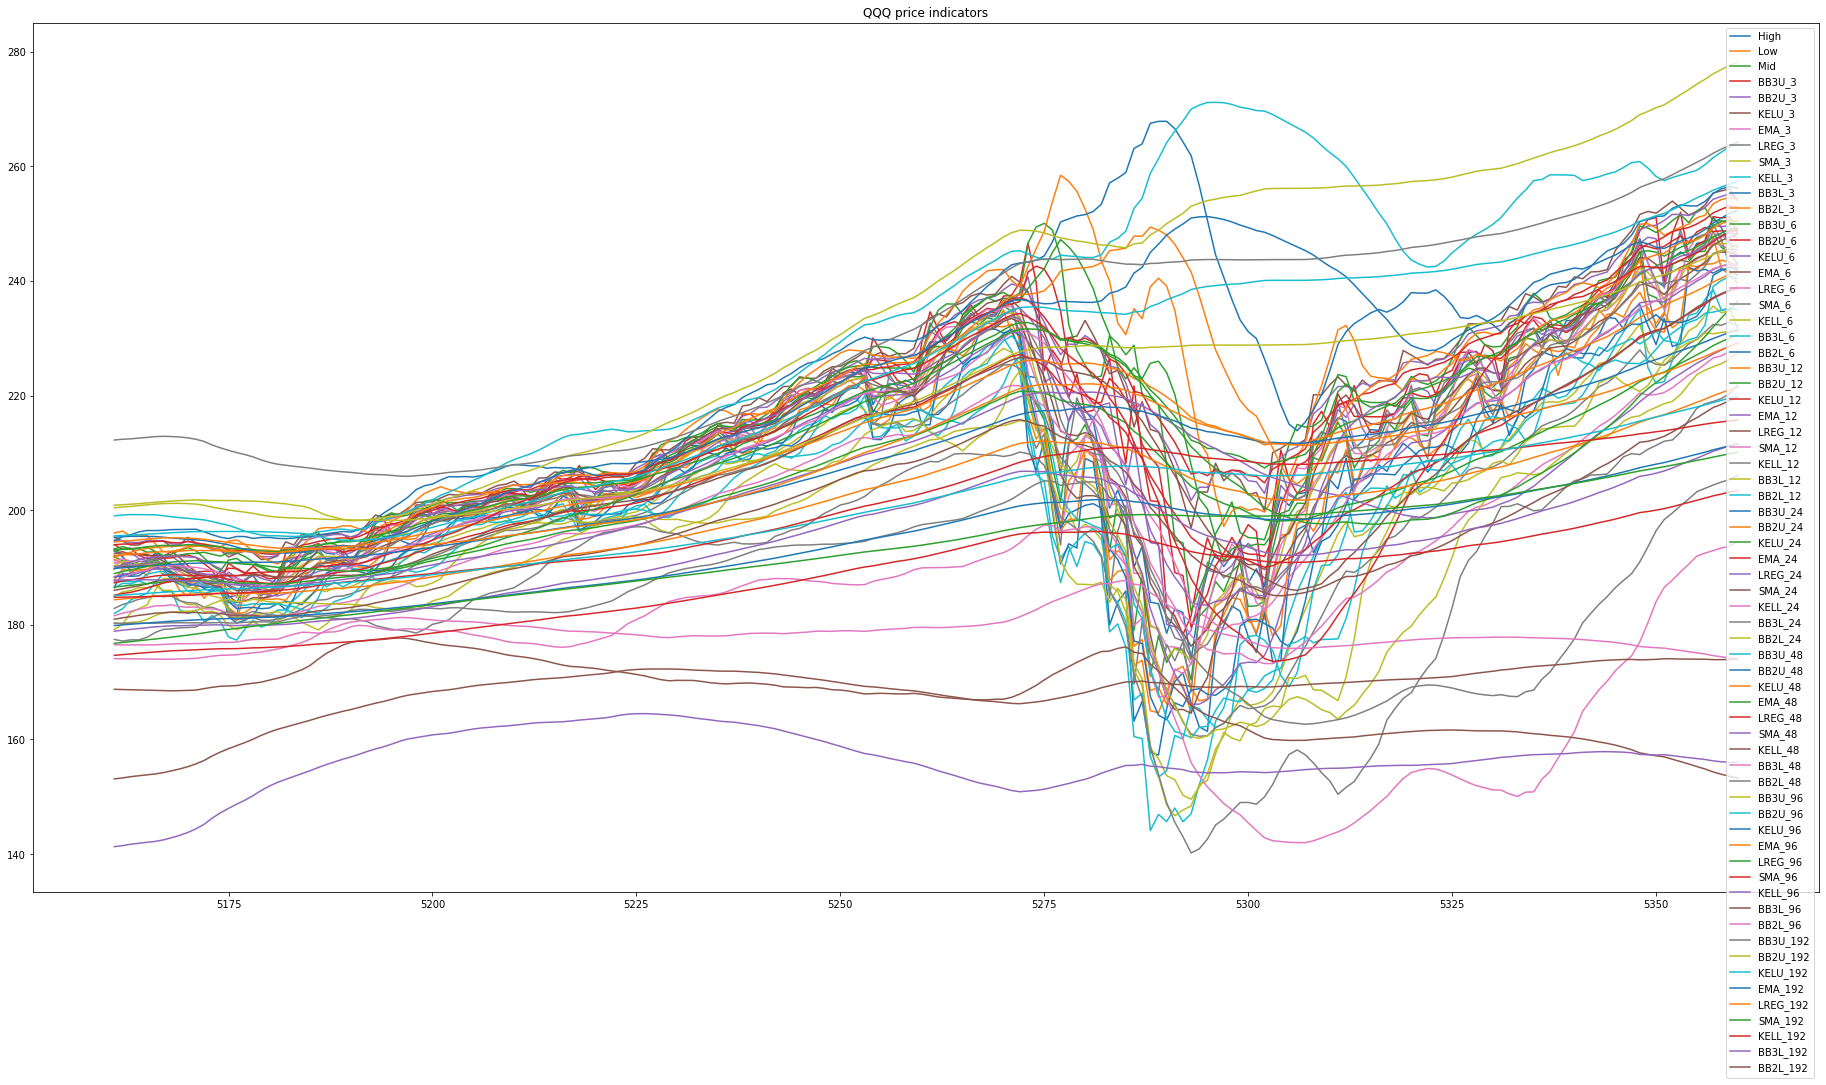

In [11]:
# add the price indicators to the dataframe
price_df = get_price_indicators(df, indicator_spread)
# plot the dataframe with the indicators
price_df.tail(WINDOW).plot(kind="line", title=f"{symbol} price indicators", figsize=(32,16))
# re-add the volume series
# # store the values
# %store volume
# %store indicator_spread
# %store WINDOW
# %store price_df

In [28]:
def get_eom_oscillator_frame(df: pd.DataFrame, window:int, periods: Tuple[int])->pd.DataFrame:
    f = pd.DataFrame(index=df.index)
    for i in periods:
        f[f'EOM_{i}'] = ind.eom(df['Volume'].values, df['Close'].values, window, i)
    return f

eom_df = get_eom_oscillator_frame(df, WINDOW, indicator_spread)

[       nan        nan        nan ... 0.47766926 0.45821686 0.46175942]
[       nan        nan        nan ... 0.43926993 0.44350744 0.44922896]
[       nan        nan        nan ... 0.43115726 0.43163775 0.43847195]
[       nan        nan        nan ... 0.42740002 0.42820051 0.42924661]
[       nan        nan        nan ... 0.43315248 0.43517915 0.4355978 ]
[       nan        nan        nan ... 0.42726245 0.42733815 0.42589055]
[       nan        nan        nan ... 0.46777079 0.46717041 0.46711079]


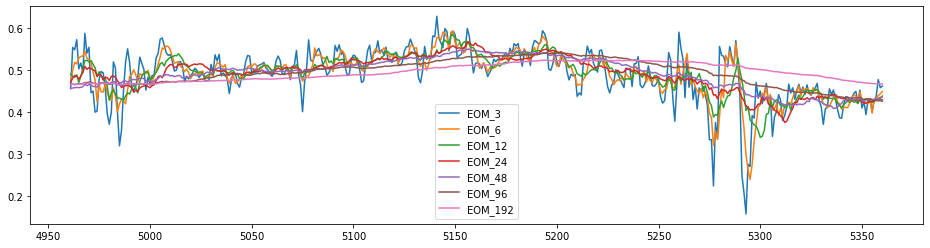

In [30]:
eom_df.tail(WINDOW*2).plot(figsize=(16,4))

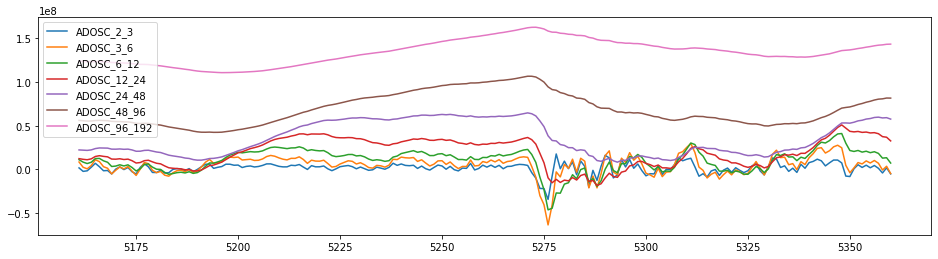

In [14]:
# set up the volume indicators RSI = abstract.RSI
ADOSC = abstract.ADOSC

def get_adosc_oscillator_frame(df: pd.DataFrame, periods: Tuple[int])->pd.DataFrame:
    f = pd.DataFrame(index=df.index)
    pre = 2
    for i in periods:
        f[f'ADOSC_{pre}_{i}'] = pd.Series(ADOSC(df["High"], df["Low"], df["Close"], df["Volume"], pre, i))
        pre = i
    return f

adosc_df = get_adosc_oscillator_frame(df, indicator_spread)
adosc_df.tail(WINDOW).plot(figsize=(16,4))

In [15]:
def create_pixels(s)->():
    # crete pixels where green and blue values are tanh normalized percent change values
    # red indicates negative percent change, green indicates positive percent change
    pc = np.tanh(s.pct_change())
    g = np.where(pc > 0, pc * s + (1. - s), 0.0)
    r = np.where(pc < 0, -pc * s + (1. - s), 0.0)
    return r, g, s

def min_max_all(df: pd.DataFrame)->pd.DataFrame:
    max_v: np.Float = None
    min_v: np.Float = None

    for col in df.columns:
        max_v = df[col].max() if max_v is None else max(max_v, df[col].max())
        min_v = df[col].min() if min_v is None else min(min_v, df[col].min())

    return (df - min_v) / (max_v - min_v)


def create_image(dataframes: list, idx, window):
    idf: pd.DataFrame = None
    columns = []
    for df in dataframes:
        # normalize the price-relative data across
        norm_df = min_max_all(df.iloc[idx:idx+window])

        if idf is None:
            idf = pd.DataFrame(index=norm_df.index)

        for col in norm_df.columns:
            columns.append(col)
            idf[col + '_r'], idf[col + '_g'], idf[col + '_b'] = create_pixels(norm_df[col])
    # todo: handle oscillator values
    # image h x w = window size x number of features. 3 = rgb values
    idf = idf.dropna().reset_index(drop=True)
    img1 = np.zeros((len(idf), len(columns), 3))
    for i, row in idf.iterrows():
        vals = []
        for col in columns:
            vals.append((row[col+'_r'], row[col+'_g'], row[col+'_b']))
        img1[i] = tuple(vals)
    return img1

fig = plt.figure(figsize=(16,16))
columns = 4
rows = 4
cnt = 0
start = WINDOW+192
for i in range(0, columns * rows):
    fig.add_subplot(rows, columns, i+1)
    im_array = create_image([price_df, adosc_df, eom_df], i+start, WINDOW)
    plt.imshow(im_array)
plt.show()

NameError: name 'eom_df' is not defined

In [16]:
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
df["ADOSC_F"] = pd.Series(AD(df["High"], df["Low"], df["Close"], df["Volume"], 10))
df["ADOSC_M"] = pd.Series(AD(df["High"], df["Low"], df["Close"], df["Volume"], 20))
df["ADOSC_S"] = pd.Series(AD(df["High"], df["Low"], df["Close"], df["Volume"], 50))
df["RSI_F"] = pd.Series(RSI(df["Close"], 5))
df["RSI_M"] = pd.Series(RSI(df["Close"], 20))
df["RSI_S"] = pd.Series(RSI(df["Close"], 50))
bbu, _, bbl = BBANDS(df["Close"], 10, 2., 2.)
df["BBU2_F"], df["BBL2_F"] = (pd.Series(bbu), pd.Series(bbl))
bbu, _, bbl = BBANDS(df["Close"], 20, 2., 2.)
df["BBU2_M"], df["BBL3_M"] = (pd.Series(bbu), pd.Series(bbl))
bbu, _, bbl = BBANDS(df["Close"], 30, 2., 2.)
df["BBU2_S"], df["BBL3_S"] = (pd.Series(bbu), pd.Series(bbl))
bbu, _, bbl = BBANDS(df["Close"], 10, 3., 3.)
df["BBU3_F"], df["BBL3_F"] = (pd.Series(bbu), pd.Series(bbl))
bbu, _, bbl = BBANDS(df["Close"], 20, 3., 3.)
df["BBU3_M"], df["BBL3_M"] = (pd.Series(bbu), pd.Series(bbl))
bbu, _, bbl = BBANDS(df["Close"], 30, 3., 3.)
df["BBU3_S"], df["BBL3_S"] = (pd.Series(bbu), pd.Series(bbl))

df['EOM_F'] = ind.easy_of_movement(df["Volume"], df["Open"], df["Close"], 10).rolling(6).mean()
df['EOM_M'] = ind.easy_of_movement(df["Volume"], df["Open"], df["Close"], 20).rolling(6).mean()
df['EOM_S'] = ind.easy_of_movement(df["Volume"], df["Open"], df["Close"], 50).rolling(6).mean()

# df['AVGD_F'] = ind.avg_price_change(df["Open"], df["Close"], 10)
# df['AVGD_M'] = ind.avg_price_change(df["Open"], df["Close"], 20)
# df['AVGD_S'] = ind.avg_price_change(df['Open'], df['Close'], 50)

# VS columns


fig = plt.figure(figsize=(8,8))
columns = 2
rows = 2
df.dropna(inplace=True)
for i in range(0, columns * rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(create_image(df, i, WINDOW))
plt.show()
    #
# df["TARGET"] = ind.percent_future_change(df)
# df["EOM"] = ind.easy_of_movement(df["Volume"], df["Open"], df["Close"], 50).rolling(6).mean()
# df["RSIV32"] = ind.rsi_volume(df["Volume"], df["Open"], df["Close"], 32, 2) / 100
# df["KELU32"], df["KELL32"], df["EMA32"] = ind.keltner_channels(df["High"], df["Low"], df["Close"], 32)
# df["SQZ"] = ind.squeeze(df["BB32U"], df["BB32L"], df["KELU32"], df["KELL32"]).astype(int)
# chart_num = 200
#
# # plot the dataframe with the indicators
# df[[
#     "MID",
#     "SMA32",
#     "SMA64",
#     "SMA6",
#     "BB20U",
#     "BB20M",
#     "BB20L",
#     "KELU32",
#     "KELL32",
#     "EMA32",
# ]].tail(chart_num)\
#     .plot(kind="line", title=f"{symbol} 5y Daily Mid", figsize=(32,32), ax=ax1)
# df["ADOSC"].tail(chart_num).plot(kind="bar", ax=ax2, title="ADOSC")
# # df["%volchange"].tail(chart_num).plot(ax=ax3, title="%vol change")
# df[["EOM", "MID"]].tail(chart_num).plot(ax=ax3, title="easy_of_movement", secondary_y=["MID"])
# df[["RSIV32", "RSI32", "MID"]].tail(chart_num).plot(ax=ax4, title="flow", secondary_y=["MID"])
%store df

NameError: name 'AD' is not defined

## create synthetic values

In [17]:
chart_num = 100

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6)

df["SMA6_CD"] = ind.convergence_divergence_min_max(df["MID"], df["SMA6"], 6, 0)
df["SMA32_CD"] = ind.convergence_divergence_min_max(df["MID"], df["SMA32"], 32)
df["SMA64_CD"] = ind.convergence_divergence_min_max(df["MID"], df["SMA64"], 64)
df["MIN_MAX_MID"] = ind.trend_min_max(df["MID"])

df["SMA6_MID_P"] = ind.difference_percentage_change(df["MID"], df["SMA6"], 6, 6)
df["SMA32_MID_P"] = ind.difference_percentage_change(df["MID"], df["SMA32"], 6, 32)
df["SMA64_MID_P"] = ind.difference_percentage_change(df["MID"], df["SMA64"], 6, 64)

df["SMA6_SMA32_P"] = ind.difference_percentage_change(df["SMA6"], df["SMA32"], 10, 32)
df["SMA32_SMA64_P"] = ind.difference_percentage_change(df["SMA32"], df["SMA64"], 10, 64)
df["SMA6_SMA64_P"] = ind.difference_percentage_change(df["SMA6"], df["SMA64"], 10, 64)

df["RESLP32"] = ind.regression_slope_min_max(df["MID"], 32)
df["RESLP6"] = ind.regression_slope_min_max(df["MID"], 6)
df["REG6"] = ind.rolling_regression(df["MID"], 6)
df["REGP6_2"] = ind.rolling_regression_poly(df["MID"], 6)
# predict 2 periods into the future
df["REGP16_2_1"] = ind.rolling_regression_poly(df["MID"], 16, 2, 1)
# df["regp_16_2_0"] = rolling_regression_poly(df["Close"], 16, 2, 0)
# df["regp_32_2_0"] = rolling_regression_poly(df["Close"], 32, 2, 0)
df["REGP32_2_1"] = ind.rolling_regression_poly(df["MID"], 32, 2, 1)
df["REGP64_2_1"] = ind.rolling_regression_poly(df["MID"], 64, 2, 1)
df["REGBF32_6_1"] = ind.rolling_best_fit_regression(df["MID"], 32, 6, 1)
df["BB20_CDP"] = ind.difference_percentage_change(df["BB20U"], df["BB20L"], 6, 20)

df[["SMA32_CD",
    "SMA64_CD",
    "MIN_MAX_MID",
    "TARGET"]].tail(chart_num).head(200).plot(title="", ax=ax1, secondary_y="TARGET")

chartDf = df[["MID", "REGP16_2_1", "REGP64_2_1", "REGP32_2_1", "REGBF32_6_1"]]
# add 1 blank rows to the chart
chartDf.loc[max(df.index) + 1, :] = None
chartDf["REGP64_2_1"] = chartDf["REGP64_2_1"].shift(1)
chartDf["REGP16_2_1"] = chartDf["REGP16_2_1"].shift(1)
chartDf["REGP32_2_1"] = chartDf["REGP32_2_1"].shift(1)
chartDf["REGBF32_6_1"] = chartDf["REGBF32_6_1"].shift(1)
chartDf.tail(chart_num).plot(title="regression", grid=True, figsize=(32,64), ax=ax2)

df[["RESLP32", "RESLP6"]].tail(chart_num).plot(title="regression slope", ax=ax3)
df["BB20_CDP"].tail(chart_num).plot(title="bbands % change", ax=ax4)

df[["SMA6_MID_P",
    "SMA32_MID_P",
    "SMA64_MID_P",
    "SMA6_SMA64_P",
    "MID"]].tail(chart_num).plot(title="SMA v MID Percentage Change", ax=ax5, secondary_y="MID")

df[["SMA6_SMA32_P",
    "SMA32_SMA64_P",
    "MID"]].tail(chart_num).plot(title="SMA v SMA Percentage Change", ax=ax6, secondary_y="MID")

%store df

AttributeError: module 'indicators.indicators' has no attribute 'convergence_divergence_min_max'

## normalize the data for ML algos

In [18]:
from indicators import normalize as nm

pd.set_option('display.max_rows', 100)

output_file = os.path.join(os.getcwd(), "..", "data", f"{symbol}.csv")

# create the df that will be saved for training
out_df = pd.DataFrame(index=df.index)
out_df["TARGET"] = nm.discretize_series(df["TARGET"],
                                        # bins=(0, .2, .4, .6, .8, 1),
                                        bins=5,
                                        labels=("--", "-", "=", "+", "++"))
                                        # labels=False)
bins = (-.1, .1, .2, .3, .4, .5, .6, .7, .9, 1, 1.1)
labels = (.1, .2, .3, .4, .5, .6, .7, .8, .9, 1)

# DISCRETIZE ALL THE THINGS
out_df["EOM"] = pd.cut(df["EOM"], bins=bins, labels=labels, include_lowest=True)
out_df["SMA32_CD"] = pd.cut(df["SMA32_CD"], bins=bins, labels=labels, include_lowest=True)
out_df["SMA64_CD"] = pd.cut(df["SMA64_CD"], bins=bins, labels=labels, include_lowest=True)
out_df["MIN_MAX_MID"] = pd.cut(df["MIN_MAX_MID"], bins=bins, labels=labels, include_lowest=True)
out_df["RESLP32"] = pd.cut(df["RESLP32"], bins=bins, labels=labels, include_lowest=True)
out_df["BB20_CDP"] = pd.cut(df["BB20_CDP"], bins=bins, labels=labels, include_lowest=True)
out_df["BB20_CDP"] = pd.cut(df["BB20_CDP"], bins=bins, labels=labels, include_lowest=True)
out_df["RESLP32"] = pd.cut(df["RESLP32"], bins=bins, labels=labels, include_lowest=True)
out_df["RESLP6"] = pd.cut(df["RESLP6"], bins=bins, labels=labels, include_lowest=True)
out_df["BB20_CDP"] = pd.cut(df["BB20_CDP"].rolling(20).apply(nm.min_max), bins=bins, labels=labels, include_lowest=True)
out_df["RSIV32"] = pd.cut(df["RSIV32"], bins=bins, labels=labels, include_lowest=True)
# signal boolean columns
out_df["SQZ"] = df["SQZ"]
# relationship boolean columns
out_df["REGP6_GTE_MID"] = (df["REGP6_2"] >= df["MID"]).astype(int)
out_df["REGP32_GTE_MID"] = (df["REGP32_2_1"] >= df["MID"]).astype(int)
out_df["REGP64_GTE_MID"] = (df["REGP64_2_1"] >= df["MID"]).astype(int)
out_df["SMA6_GTE_SMA32"] = (df["SMA6"] >= df["SMA32"]).astype(int)
out_df["SMA32_GTE_SMA64"] = (df["SMA32"] >= df["SMA64"]).astype(int)
out_df["SMA6_GTE_MID"] = (df["SMA6"] >= df["MID"]).astype(int)
out_df["SMA32_GTE_MID"] = (df["SMA32"] >= df["MID"]).astype(int)
out_df["SMA64_GTE_MID"] = (df["SMA64"] >= df["MID"]).astype(int)
out_df["EMA32_GTE_SMA32"] = (df["EMA32"] >= df["SMA32"]).astype(int)
out_df["HIGH_GTE_BB20U"] = (df["High"] >= df["BB20U"]).astype(int)
out_df["LOW_LTE_BB20L"] = (df["Low"] <= df["BB20L"]).astype(int)
# directional boolean columns
out_df["REGP6+"] = (df["REGP6_2"] >= df["REGP6_2"].shift(-1)).astype(int)
out_df["REGP32+"] = (df["REGP32_2_1"] >= df["REGP32_2_1"].shift(-1)).astype(int)
out_df["SMA6+"] = (df["SMA6"] >= df["SMA6"].shift(-1)).astype(int)
out_df["SMA32+"] = (df["SMA32"] >= df["SMA32"].shift(-1)).astype(int)
out_df["SMA64+"] = (df["SMA64"] >= df["SMA64"].shift(-1)).astype(int)
out_df["EOM+"] = (df["EOM"] >= df["EOM"].shift(-1)).astype(int)
out_df["MID+"] = (df["MID"] >= df["MID"].shift(-1)).astype(int)
out_df["HIGH+"] = (df["High"] >= df["High"].shift(-1)).astype(int)
out_df["LOW+"] = (df["Low"] >= df["Low"].shift(-1)).astype(int)
out_df["CLOSE"] = (df["Close"] >= df["Close"].shift(-1)).astype(int)
print(out_df.tail(100))
# drop NA rows, and write to csv
out_df.dropna().to_csv(output_file, index=False)

AttributeError: module 'indicators.normalize' has no attribute 'discretize_series'

## Base Line P/Ls

import copy

trades = pd.DataFrame(columns=["index", "open_price", "direction", "periods", "+/-", "p/l"])

pos = {
    "index": 0,
    "periods": 0,
    "p/l": 0,
}

open_position = None

rows = []

num_buys = 10
CMP = "SMA6"

# test trading  based on cvd
for i, row in df.iterrows():
    if open_position is not None:
        open_position["periods"] += 1
        if open_position["direction"] == "long":
            open_position["p/l"] = (row["Close"] - open_position["open_price"]) * num_buys
        else: 
            open_position["p/l"] = (open_position["open_price"] - row["Close"]) * num_buys

    if row["reg"] > row[CMP] and df[CMP][i-1] > df["reg"][i-1] \
            and row["reg_slope"] > 0:
    # if row["reg"] > row[CMP] and df[CMP][i-1] > df["reg"][i-1] and row["reg_slope"] > 0:
    # if row["sma32_cvd"] < -0.9:
        if open_position is not None and i > 1:
            open_position["close_price"] = row["Close"]
            rows.append(copy.copy(open_position))
            open_position = None
        open_position = {
            "open_price": row["Close"],
            "direction": "long",
            "index": i,
            "periods": 0,
            "p/l": 0,
        }
            
    # elif row["reg"] < row[CMP] and df[CMP][i-1] < df["reg"][i-1] and row["reg_slope"] < 0  and row["sma32_cvd"] > 0:
    elif row["reg"] < row[CMP] and df[CMP][i-1] < df["reg"][i-1] \
            and row["reg_slope"] < 0:
        
        if open_position is not None and i > 1:
            open_position["close_price"] = row["Close"]
            rows.append(copy.copy(open_position))
            open_position = None
            
        open_position = {
            "open_price": row["Close"],
            "direction": "short",
            "index": i,
            "periods": 0,
            "p/l": 0,
        }
        
    if open_position is not None:
        if open_position["direction"] == "long" \
                and row["reg"] < row[CMP] and df[CMP][i-1] < df["reg"][i-1]:
        # if row["sma32_cvd"] > 0.5:
            open_position["close_price"] = row["Close"]
            rows.append(copy.copy(open_position))
            open_position = None
        
        elif open_position["direction"] == "short" \
                and row["reg"] > row[CMP] and df[CMP][i-1] > df["reg"][i-1]:
           open_position["close_price"] = row["Close"]
           rows.append(copy.copy(open_position))
           open_position = None

trades = pd.DataFrame(rows)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(trades)
    print(trades["p/l"].sum())
    print(trades[trades["p/l"] > 0]["p/l"].count())